In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../Data/train.csv")
data.head(100)

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.000,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.000,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.000,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.000,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.000,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,The Beatles,She's Leaving Home - Remastered,NaN,0.381,0.214,4.0,-11.629,1,0.0337,0.944000,NaN,0.1060,0.3930,127.581,3.586,3,0
96,Tom The Mail Man,Taking Over,60.0,0.762,0.516,5.0,-8.016,0,0.0969,0.028800,NaN,0.0966,0.7210,156.970,158000.000,4,5
97,ANSON,Ghost,28.0,0.357,0.943,4.0,-6.168,0,0.1010,0.000547,NaN,0.1450,0.4820,147.217,209682.000,4,10
98,Jimmy Eat World,All The Way (Stay),38.0,0.576,0.931,7.0,-2.491,1,0.0563,0.000850,NaN,0.1430,0.7350,133.986,245747.000,4,10


In [4]:
#Проверим тип данных во всех столбцах
data.info()
#Все численные переменные кроме Artist Name и Track Name

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

 Hello, I'm an assistant, my name is Rex 🦖. Today I will be your guide to the world of your dataframe.

1) Number of columns: 17,
   Number of row: 17996

2) Numerical columns: ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms'],
   String columns: ['Artist Name', 'Track Name'],
   Categorical columns:  ['key', 'mode', 'time_signature', 'Class']

3) Number of values and their frequencies:

key
╭────────┬─────────┬──────────────╮
│   Name │   Count │   Frequences │
├────────┼─────────┼──────────────┤
│      7 │    2097 │        0.131 │
│      2 │    1994 │        0.125 │
│      9 │    1961 │        0.123 │
│      1 │    1680 │        0.105 │
│      4 │    1549 │        0.097 │
│     11 │    1476 │        0.092 │
│      5 │    1397 │        0.087 │
│      6 │    1190 │        0.074 │
│      8 │    1119 │        0.07  │
│     10 │    1010 │        0.063 │
│      3 │     509 │        0

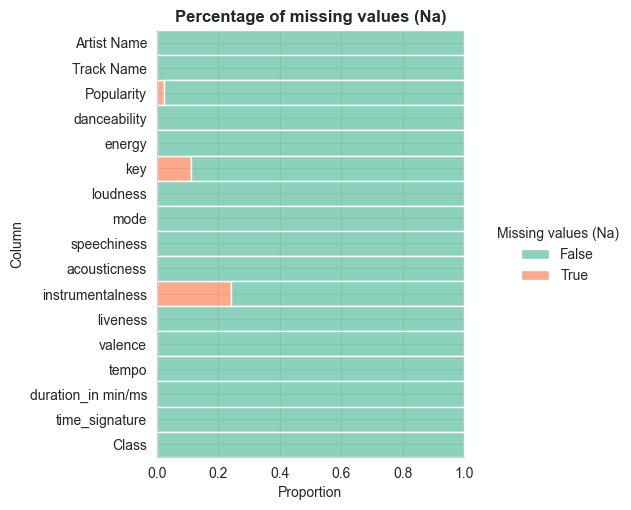

In [5]:
#Запустим скрипт для EDA
#Посмотрим на то, какие из переменных могут быть категориальными (в скрипте стоит порог: df[column].nunique() >= 12)
#На баланс классов в переменных, которые предположительно являются категориальными
#Проверим на выбросы
#Количество NA
#Посмотрим на базовые статистики для численных переменных 
from my_awesome_eda import run_eda
run_eda(data)

In [6]:
#Переведем переменные Class, time_signature и mode в category
data.Class = data.Class.astype('category')
data.time_signature = data.time_signature.astype('category')
data['mode'] = data['mode'].astype('category')
data['key'] = data['key'].astype('category')
numeric_column = data.select_dtypes(include=np.number).columns.tolist()

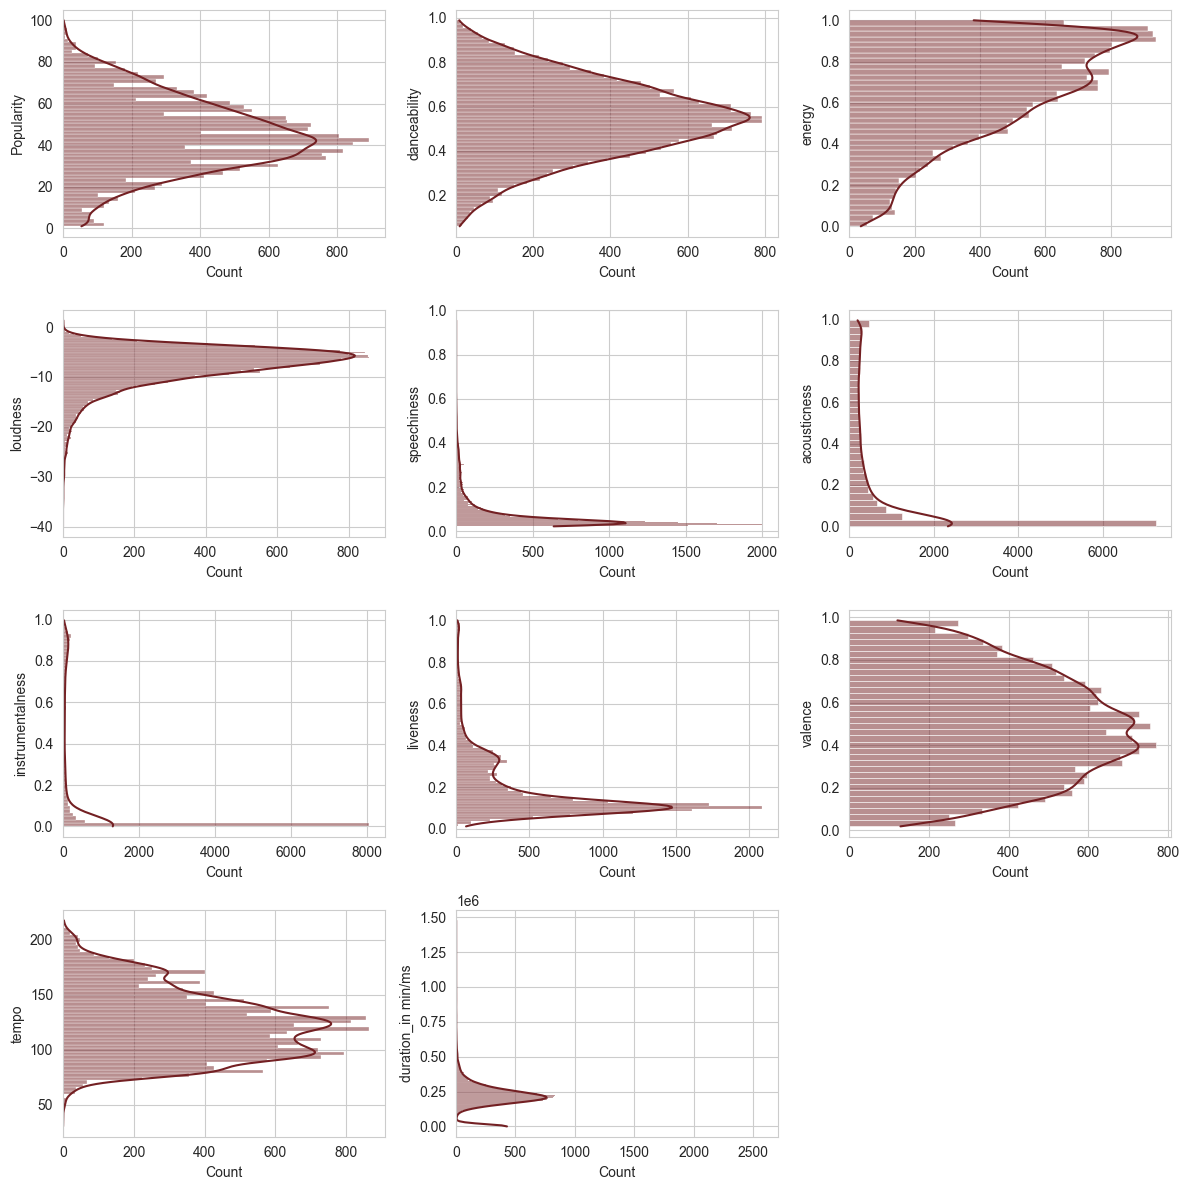

In [7]:
#Посмотрим на распределение данных в численных переменных
plt.figure(figsize=(12, 12))
i = 1
for col in data[numeric_column]:
    plt.subplot(4, 3, i)
    sns.histplot(y=data[col], color='#732023', kde=True, )
    i += 1

plt.tight_layout();

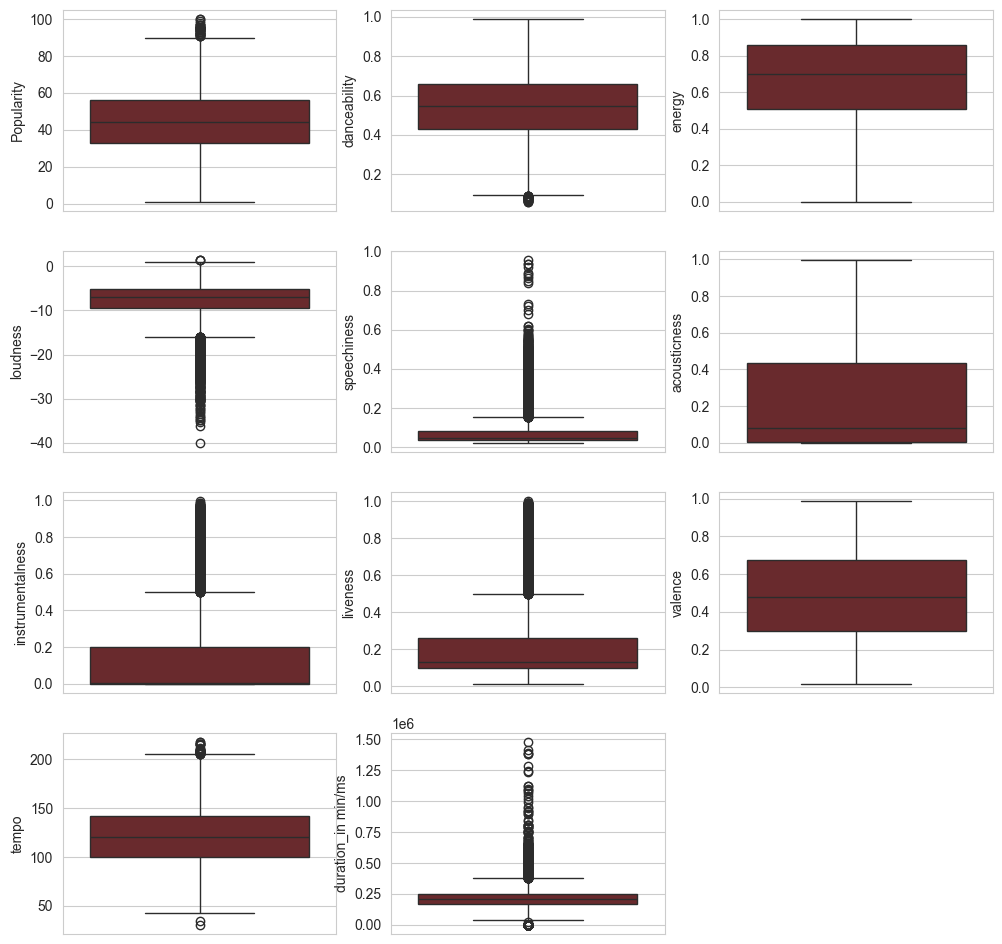

In [8]:
plt.figure(figsize=(12, 12))
i = 1
for col in data[numeric_column]:
    plt.subplot(4, 3, i)
    sns.boxplot(y=data[col], color='#732023')
    i += 1


In [9]:
#Удалим выбросы
data_no_outliers = data.drop(index=[np.argmin(data.loudness), np.argmin(data.tempo)])
data_no_outliers = data_no_outliers.drop(index=np.argmin(data_no_outliers.tempo))
#Поскольку остальные выбросы находятся в куче не будем их удалять
#Переведeм все значения в столбце duration_in min/ms в минуты, чтобы не было большого разрыва в данных
data_no_outliers.loc[data_no_outliers['duration_in min/ms'] > 1000, 'duration_in min/ms'] /= 60000

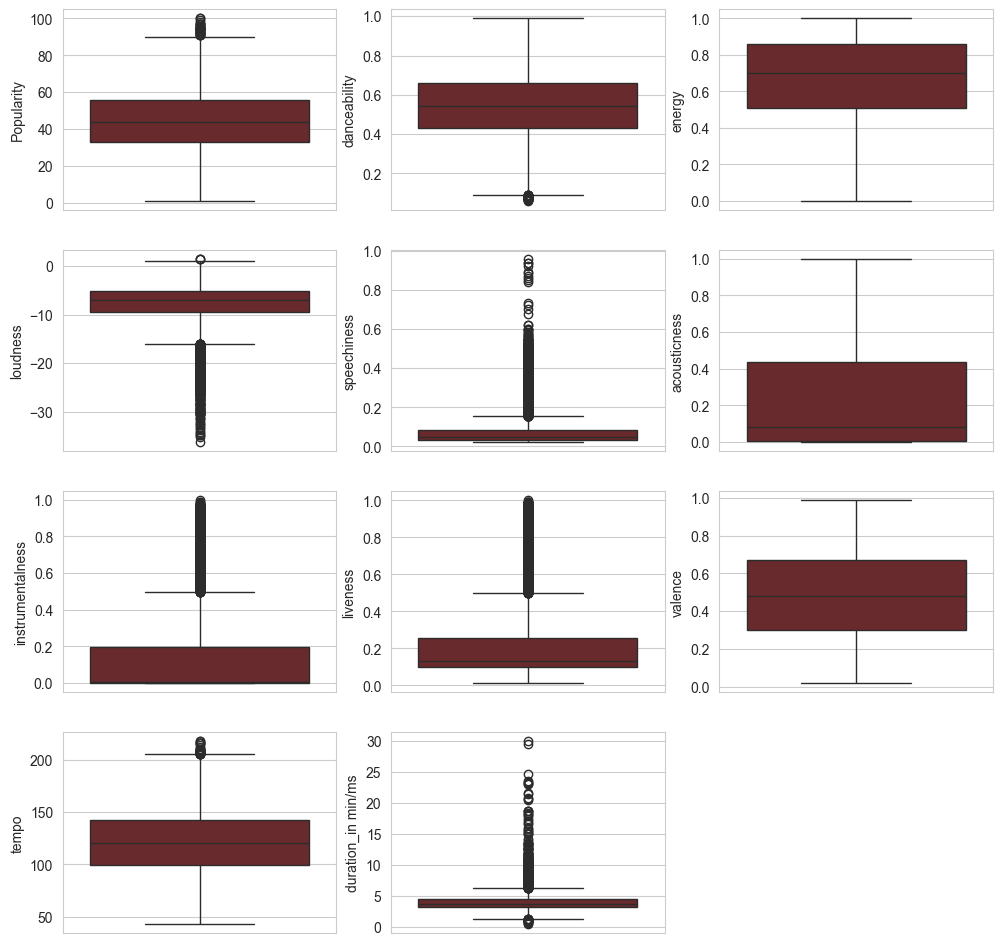

In [10]:
plt.figure(figsize=(12, 12))
i = 1
for col in data_no_outliers[numeric_column]:
    plt.subplot(4, 3, i)
    sns.boxplot(y=data_no_outliers[col], color='#732023')
    i += 1


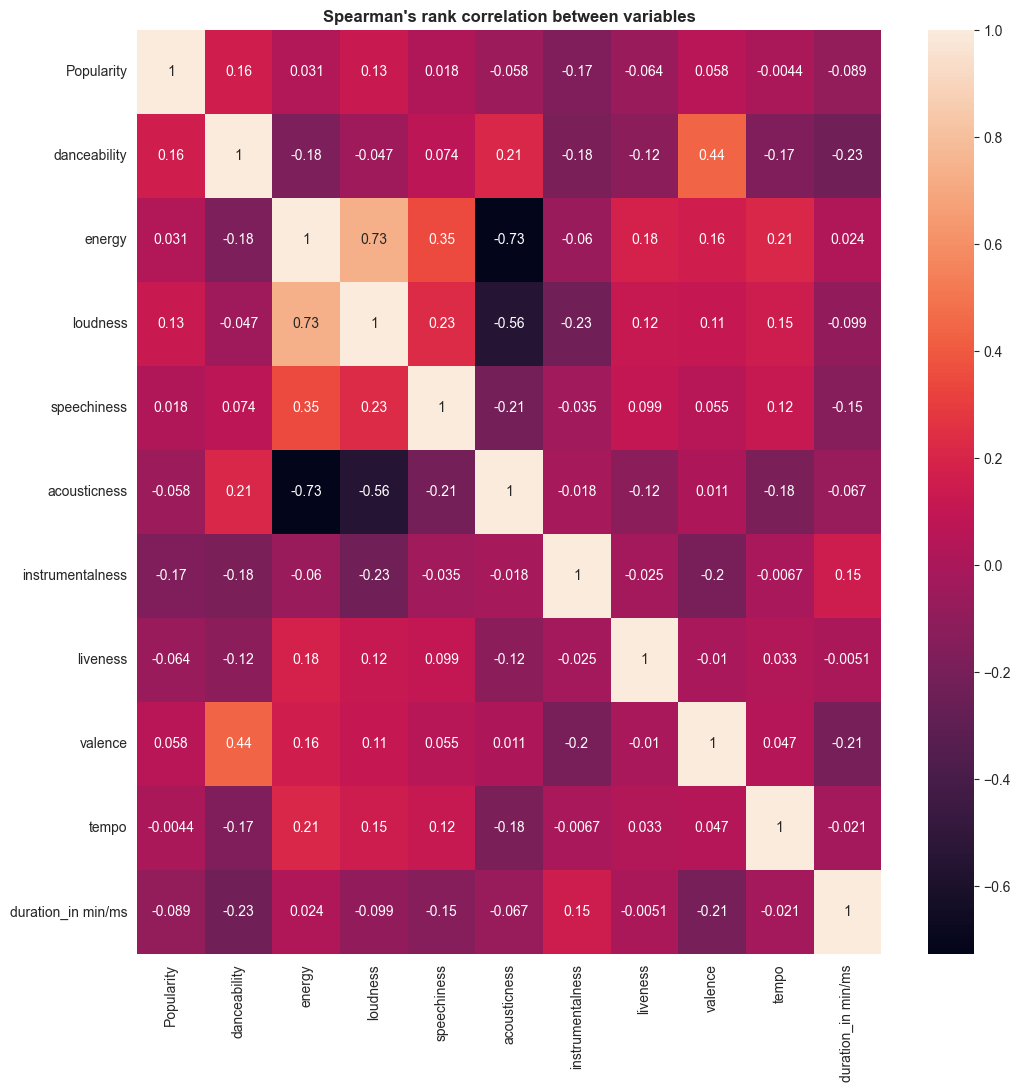

In [11]:
#Проверим данные на нормальность (с использованием Шапиро-Уилка) и посчитаем корреляцию
plt.figure(figsize=(12, 12))
parametric = True
for column in numeric_column:
    if shapiro(data_no_outliers[column]).pvalue < 0.05:
        parametric = False
if parametric:
    df_corr = data_no_outliers.corr(numeric_only=True)
    sns.heatmap(df_corr, annot=True)
    plt.title("Pearson сorrelation between variables", weight="bold")
if not parametric:
    df_corr = data_no_outliers.corr(numeric_only=True, method='spearman')
    sns.heatmap(df_corr, annot=True)
    plt.title("Spearman's rank correlation between variables", weight="bold")

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [13]:
#Для построения модели уберем колонки "Artist Name", "Track Name", поскольку они имеют большое количество уникальных значений, а также уберем колонку Energy, потому что она сильно коррелирует с двумя другими переменными
data_no_outliers = data_no_outliers.drop(["Artist Name", "Track Name", "energy"], axis=1)


In [14]:
#Будем предсказывать переменную жанр трека (Class)
target = data_no_outliers.Class
X = data_no_outliers.drop('Class', axis=1)

In [15]:
#Разобьем выборку на тестовую и тренировочную
train_x, test_x, train_y, test_y = train_test_split(X , target, test_size=0.25, random_state=SEED,
                                                    stratify=target)

In [16]:
#Сделаем трансформатор для данных
category_column = ['key', 'mode', 'time_signature']
numeric_column = ['Popularity','danceability','loudness','speechiness','acousticness','instrumentalness', 'liveness', 'valence', 'tempo','duration_in min/ms']
#Будем использовать OneHotEncoder для категориальных переменных и StandartScaler для числовых
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numeric_column), ('one', OneHotEncoder(), category_column)])

In [17]:
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Popularity', 'danceability', 'loudness',
                                  'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'duration_in min/ms']),
                                ('one', OneHotEncoder(),
                                 ['key', 'mode', 'time_signature'])])

In [18]:
#Сделаем пайплайн
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model_tree', DecisionTreeClassifier())])
#Обучим модель и предскажем значения
model_pipeline.fit(train_x, train_y)
y_pred = model_pipeline.predict(test_x)

In [19]:
#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, y_pred, average="macro")}')
#В целом, метрики достаточно низкие (поскольку баланс классов не соблюдается в выборках, будем основное внимание уделять метрикам F1_score и accuracy)

Accuracy = 0.37341631473660813
Precision = 0.3619432802522394
Recall = 0.3580102186359274
F1_score = 0.3588014756983679


In [20]:
#Попробуем подобрать оптимальные гиперпараметры для модели
param_grid = {"model_tree__criterion": ["gini", "entropy"],
         "model_tree__splitter": ["best", "random"],
         "model_tree__max_depth": (list(range(1, 20))),
         "model_tree__min_samples_leaf": list(range(1, 15)),
         "model_tree__min_samples_split": list(range(1, 5))}

grid = GridSearchCV(model_pipeline, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Popularity',
                                                                          'danceability',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_in '
                                                                          'min/ms']),
                                                                        ('one',
                                                                         OneHotEncoder(),
                                                                         ['key',
                                                                          'mode',
                                                                          'time_signature'])])),
                                       ('model_tree',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model_tree__criterion': ['gini', 'entropy'],
                         'model_tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19],
                         'model_tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14],
                         'model_tree__min_samples_split': [1, 2, 3, 4],
                         'model_tree__splitter': ['best', 'random']},
             scoring='f1_macro')

In [21]:
#Посмотрим на подобранные гиперпараметры модели
print(f"\033[1;36m Наилучшие гиперпараметры для модели: \033[0m {grid.best_params_}")
print(f"\033[1;32m F1_score: \033[0m {grid.best_score_}")
#Модель стала чуть-чуть лучше, чем была при дефолтных гиперпараметрах

 Наилучшие гиперпараметры для модели:  {'model_tree__criterion': 'gini', 'model_tree__max_depth': 15, 'model_tree__min_samples_leaf': 13, 'model_tree__min_samples_split': 3, 'model_tree__splitter': 'best'}
 F1_score:  0.3647653965667784


In [22]:
#Обучим модель и предскажем значения
best_model = grid.best_estimator_
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)

In [23]:
#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, prediction)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, prediction, average="macro")}')

Accuracy = 0.4078684152033785
Precision = 0.4056742485665273
Recall = 0.3639340404774971
F1_score = 0.37667393916115766


Несмотря на то, что мы подобрали гиперпараметры, модель стала не сильно лучше, чем была


<img src ='https://disney-planet.fr/wp-content/uploads/2015/01/timon-personnage-le-roi-lion-07-1536x858.jpg' width =600 align="center">

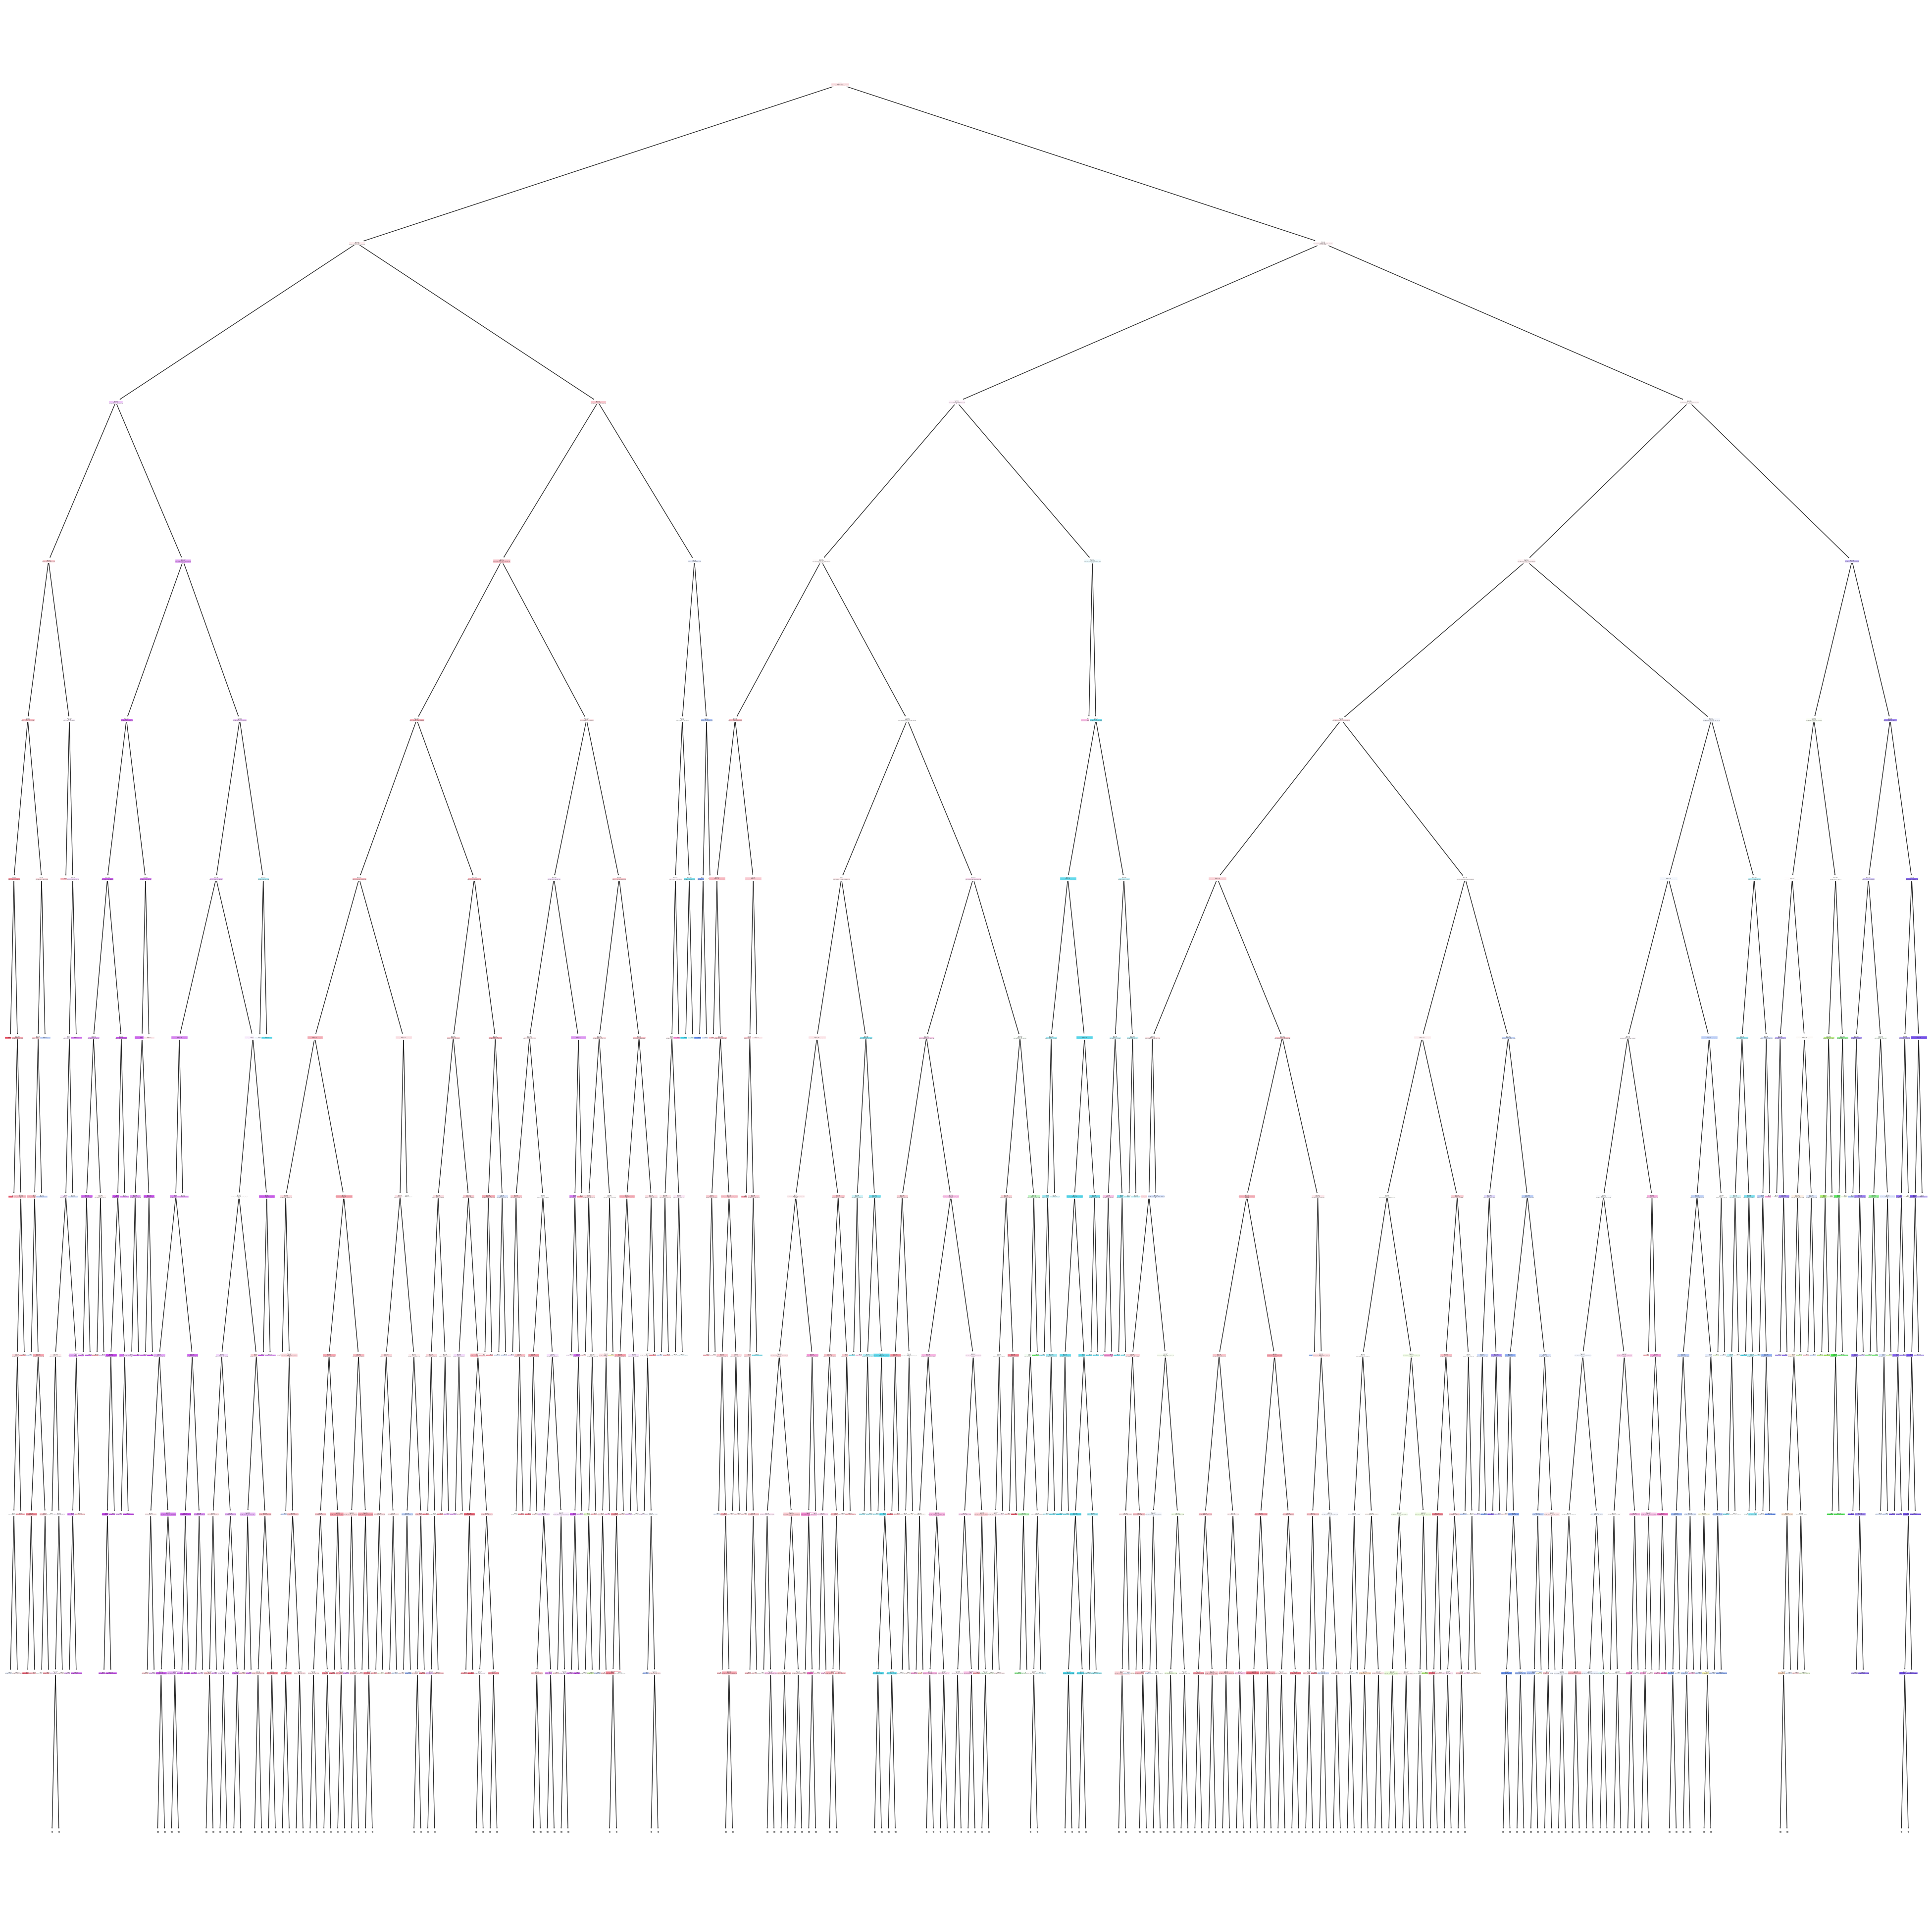

In [24]:
#Нарисуем это безобразие
plt.figure(figsize=(50,50))
plot_tree(best_model['model_tree'], filled=True, max_depth=10);

<img src ='https://i.pinimg.com/originals/6f/14/ac/6f14ac49acf9e3a917e14711465d011c.jpg' width =600 align="center">

In [25]:
#Попробуем построить модель на нестандартизованных данных
#Попробуем подобрать оптимальные гиперпараметры для модели
tree_model = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
         "splitter": ["best", "random"],
         "max_depth": (list(range(1, 15))),
         "min_samples_leaf": list(range(1, 15)),
         "min_samples_split": list(range(1, 5))}

grid = GridSearchCV(tree_model, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(train_x, train_y)
#Посмотрим на подобранные гиперпараметры модели
print(f"\033[1;36m Наилучшие гиперпараметры для модели: \033[0m {grid.best_params_}")
print(f"\033[1;32m F1_score: \033[0m {grid.best_score_}")

 Наилучшие гиперпараметры для модели:  {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 14, 'min_samples_split': 2, 'splitter': 'best'}
 F1_score:  0.3684575741738002


In [26]:
best_model = grid.best_estimator_
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)
#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, prediction)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, prediction, average="macro")}')

Accuracy = 0.35919093131807067
Precision = 0.29883635468926345
Recall = 0.2145316683213511
F1_score = 0.21483441676639636


На не стандартизованных данных метрики получились меньше

In [27]:
#А теперь какой-то прикол. Почему-то если не переводить столбец "duration_in min/ms" в одни единицы измерения (то есть все в минуты или все в миллисекунды) то метрики модели становятся лучше.
#Обработаем датафрейм немного иначе
#Удалим выбросы, но оставим колонку "duration_in min/ms" без изменений
data_no_outliers_new = data.drop(index=[np.argmin(data.loudness), np.argmin(data.tempo)])
data_no_outliers_new = data_no_outliers_new.drop(index=np.argmin(data_no_outliers_new.tempo))
data_no_outliers_new = data_no_outliers_new.drop(["Artist Name", "Track Name"], axis=1)

#Разобьем данные на тестовую и тренировочную выборки
target = data_no_outliers_new.Class
X = data_no_outliers_new.drop('Class', axis=1)
train_x, test_x, train_y, test_y = train_test_split(X , target, test_size=0.25, random_state=SEED,
                                                    stratify=target)
#Сделаем трансформатор для данных
category_column = ['key', 'mode', 'time_signature']
numeric_column = ['Popularity','danceability','loudness','speechiness','acousticness','instrumentalness', 'liveness', 'valence', 'tempo','duration_in min/ms', 'energy']
#Будем использовать OneHotEncoder для категориальных переменных и StandartScaler для числовых
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numeric_column), ('one', OneHotEncoder(), category_column)])

#Сделаем пайплайн
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model_tree', DecisionTreeClassifier())])
#Попробуем подобрать оптимальные гиперпараметры для модели
param_grid = {"model_tree__criterion": ["gini", "entropy"],
              "model_tree__splitter": ["best", "random"],
              "model_tree__max_depth": (list(range(1, 20))),
              "model_tree__min_samples_leaf": list(range(1, 15)),
              "model_tree__min_samples_split": list(range(1, 5))}

grid = GridSearchCV(model_pipeline, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(train_x, train_y)
#Посмотрим на подобранные гиперпараметры модели
print(f"\033[1;36m Наилучшие гиперпараметры для модели: \033[0m {grid.best_params_}")
print(f"\033[1;32m F1_score: \033[0m {grid.best_score_}")

 Наилучшие гиперпараметры для модели:  {'model_tree__criterion': 'gini', 'model_tree__max_depth': 12, 'model_tree__min_samples_leaf': 6, 'model_tree__min_samples_split': 4, 'model_tree__splitter': 'best'}
 F1_score:  0.5079591305124366


In [28]:
best_model = grid.best_estimator_
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)
#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, prediction)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, prediction, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, prediction, average="macro")}')

Accuracy = 0.4669926650366748
Precision = 0.5101118826073011
Recall = 0.505203721392478
F1_score = 0.5019390105904459


### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

In [29]:
#Поскольку модель логистической регресси и knn чувствительны к выбросам разберемся с ними
#Уберем колонку instrumentalness, потому что в ней большое количество пропущенных значений
data_no_outliers_nona = data_no_outliers.drop('instrumentalness', axis=1)
#Уберем строки где в колонке key - Na
data_no_outliers_nona = data_no_outliers_nona.dropna(subset='key')
#Заменим выбросы в колонке Popularity на медианные значения
data_no_outliers_nona['Popularity'] = data_no_outliers_nona['Popularity'].fillna(data_no_outliers_nona['Popularity'].median())

In [30]:
#Будем предсказывать переменную жанр трека (Class)
target = data_no_outliers_nona.Class
X = data_no_outliers_nona.drop('Class', axis = 1)
#Разобьем выборку на тестовую и тренировочную
train_x, test_x, train_y, test_y = train_test_split(X, target, test_size=0.25, random_state=SEED,
                                                    stratify=target)

In [31]:
#Сделаем трансформатор для данных
category_column = ['key', 'mode', 'time_signature']
numeric_column = ['Popularity','danceability','loudness','speechiness','acousticness', 'liveness', 'valence', 'tempo','duration_in min/ms']
#Будем использовать OneHotEncoder для категориальных переменных и StandartScaler для числовых
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numeric_column), ('one', OneHotEncoder(), category_column)])
#Построим knn классификатор
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('knn_model', KNeighborsClassifier())]) 
#Подберем оптимальный параметр для модели
knn_param = {'knn_model__n_neighbors': list(range(1,20))}
grid_knn = GridSearchCV(knn_pipeline, knn_param, cv=5, n_jobs=-1)
grid_knn.fit(train_x, train_y)
#Создадим модель с оптимальным гиперпараметром n_neighbors
knn_classifier_pipe  = Pipeline(steps=[('preprocessor', preprocessor), ('knn_model', KNeighborsClassifier(n_neighbors=grid_knn.best_params_["knn_model__n_neighbors"]))]) 
knn_classifier_pipe.fit(train_x, train_y)
#Предскажем значения 
predict_knn = knn_classifier_pipe.predict(test_x)

In [32]:
#Проверим метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, predict_knn)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, predict_knn, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, predict_knn, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, predict_knn, average="macro")}')

Accuracy = 0.4192740926157697
Precision = 0.4091934690239762
Recall = 0.3801739362972272
F1_score = 0.37853594278734415


In [33]:
#Построим модель логистической регрессии
logreg_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('log_model', LogisticRegression())]) 
logreg_pipe.fit(train_x, train_y)
prediction_logreg = logreg_pipe.predict(test_x)
#Проверим метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(test_y, prediction_logreg)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(test_y, prediction_logreg, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(test_y, prediction_logreg, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(test_y, prediction_logreg, average="macro")}')

Accuracy = 0.42202753441802254
Precision = 0.37037434850459144
Recall = 0.3623541417681431
F1_score = 0.35181013830530183


In [34]:
#Посмотрим на наиболее важные признаки
for feature, coef in zip(X.columns,abs(logreg_pipe['log_model'].coef_[0])):
    print(f"{feature}: {coef}")
#Похоже что наиболее важными признаками являются loudness, Popularity, acousticness,, mode

Popularity: 0.2656137867374982
danceability: 0.13587349442939547
key: 0.03413540279465494
loudness: 0.8413727247456579
mode: 0.6404417931518371
speechiness: 0.17512930319032607
acousticness: 0.32826317996905957
liveness: 0.1332117930396875
valence: 0.11531834343592606
tempo: 0.11479683870418399
duration_in min/ms: 0.1476358482739799
time_signature: 0.08406760049033045


### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Гарри Поттер (Первые 3 части, потом там все стало грустно и пасмурно)

2. Мстители - просто люблю фантастику

3. Еще мне нравятся фильмы про космос (Интерстеллар, Гравитация, Марсианин) и фильмы про ограбления (13 друзей Оушена, Ограбление по-итальянски, Иллюзия обмана)